## 1. Import 및 데이터 로더 구성

In [1]:
import os
import re
import pandas as pd
import numpy as np

import urllib.request
import matplotlib.pyplot as plt
%matplotlib inline


from konlpy.tag import Okt
from konlpy.tag import Mecab

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

from collections import Counter
import gensim
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors
from sklearn.model_selection import train_test_split

# tokenizer, 불용어 선언
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# pre-processing and loading data
def load_data(train_data, test_data, num_words=10000):
    '''
    1. 데이터의 중복 제거
    2. NaN 결측치 제거
    3. 한국어 토크나이저로 토큰화
    4. 불용어(Stopwords) 제거
    5. 사전word_to_index 구성
    6. 텍스트 스트링을 사전 인덱스 스트링으로 변환
    7. Return: X_train, y_train, X_test, y_test, word_to_index
    '''
    
    train_data.drop_duplicates(subset=['document'], inplace=True) #1
    train_data = train_data.dropna(how = 'any') #2
    test_data.drop_duplicates(subset=['document'], inplace=True) #1
    test_data = test_data.dropna(how = 'any') #2
    
    #3,4 
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    #5
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    #6
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [2]:
print(gensim.__version__)

3.8.1


## 2. 데이터 불러오기

In [3]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
# data load 하여 X_train, y_train, X_test, y_test, word_to_index 리턴
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [5]:
# index에서 word로 바꿔주는 dictionary
index_to_word = {index:word for word, index in word_to_index.items()}

In [6]:
len(word_to_index)

10000

저의 어디가 짱인가요?

In [7]:
print(get_decoded_sentence(X_train[10], index_to_word))
print('라벨: ', y_train[10])  # 3번째 리뷰데이터의 라벨

. 진짜 짱 다 ♥
라벨:  1


## 3. 데이터 분석 및 가공

In [8]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [9]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [10]:
# Train, val data 분리
partial_x_train, x_val, partial_y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=718)

## 4. 모델 데려오기

### 4-1. GMP

In [11]:
vocab_size = 10000
word_vector_dim = 64

GMP_model = keras.Sequential()
GMP_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
GMP_model.add(keras.layers.GlobalMaxPooling1D())
GMP_model.add(keras.layers.Dense(8, activation='gelu'))
GMP_model.add(keras.layers.Dense(1, activation='sigmoid'))
        

GMP_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          640000    
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 640,529
Trainable params: 640,529
Non-trainable params: 0
_________________________________________________________________


In [12]:
GMP_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

GMP_history = GMP_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=5,
                    batch_size=10,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
10964/10964 [==============================] - 40s 4ms/step - loss: 0.3836 - accuracy: 0.8275 - val_loss: 0.3483 - val_accuracy: 0.8493
Epoch 2/5
10964/10964 [==============================] - 39s 4ms/step - loss: 0.3089 - accuracy: 0.8687 - val_loss: 0.3402 - val_accuracy: 0.8540
Epoch 3/5
10964/10964 [==============================] - 39s 4ms/step - loss: 0.2742 - accuracy: 0.8869 - val_loss: 0.3443 - val_accuracy: 0.8546
Epoch 4/5
10964/10964 [==============================] - 39s 4ms/step - loss: 0.2476 - accuracy: 0.8990 - val_loss: 0.3548 - val_accuracy: 0.8531
Epoch 5/5
10964/10964 [==============================] - 39s 4ms/step - loss: 0.2259 - accuracy: 0.9093 - val_loss: 0.3679 - val_accuracy: 0.8509


In [13]:
results = GMP_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3760 - accuracy: 0.8462
[0.37601760029792786, 0.8461866974830627]


In [14]:
GMP_history_dict = GMP_history.history
print(GMP_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


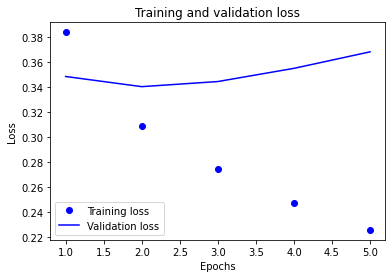

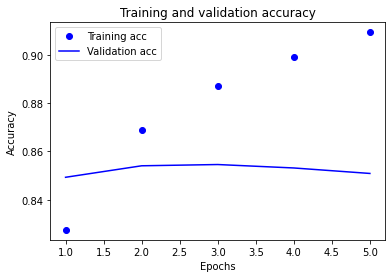

In [15]:
acc = GMP_history_dict['accuracy']
val_acc = GMP_history_dict['val_accuracy']
loss = GMP_history_dict['loss']
val_loss = GMP_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 4-2. 1-D Convolution Neural Network(1-D CNN)

In [16]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

CNN_model = keras.Sequential()
CNN_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
CNN_model.add(keras.layers.Conv1D(16, 7, activation='gelu'))
CNN_model.add(keras.layers.MaxPooling1D(5))
CNN_model.add(keras.layers.Conv1D(16, 7, activation='gelu'))
CNN_model.add(keras.layers.GlobalMaxPooling1D())
CNN_model.add(keras.layers.Dense(8, activation='gelu'))
CNN_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [17]:
CNN_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


CNN_history = CNN_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=5,
                    batch_size=10,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
10964/10964 [==============================] - 56s 5ms/step - loss: 0.3732 - accuracy: 0.8305 - val_loss: 0.3324 - val_accuracy: 0.8549
Epoch 2/5
10964/10964 [==============================] - 54s 5ms/step - loss: 0.2852 - accuracy: 0.8805 - val_loss: 0.3203 - val_accuracy: 0.8614
Epoch 3/5
10964/10964 [==============================] - 54s 5ms/step - loss: 0.2371 - accuracy: 0.9042 - val_loss: 0.3417 - val_accuracy: 0.8557
Epoch 4/5
10964/10964 [==============================] - 54s 5ms/step - loss: 0.1948 - accuracy: 0.9237 - val_loss: 0.3718 - val_accuracy: 0.8539
Epoch 5/5
10964/10964 [==============================] - 54s 5ms/step - loss: 0.1577 - accuracy: 0.9400 - val_loss: 0.4092 - val_accuracy: 0.8510


In [18]:
results = CNN_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4211 - accuracy: 0.8442
[0.421138733625412, 0.8442338109016418]


In [19]:
CNN_history_dict = CNN_history.history
print(CNN_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


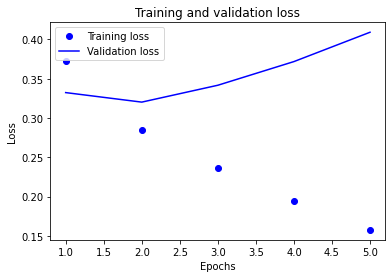

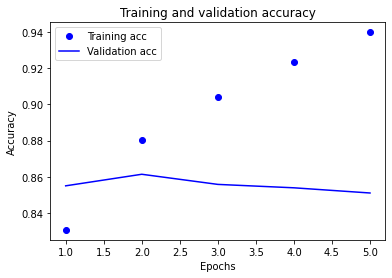

In [20]:
acc = CNN_history_dict['accuracy']
val_acc = CNN_history_dict['val_accuracy']
loss = CNN_history_dict['loss']
val_loss = CNN_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 4-3. LSTM

In [21]:
vocab_size = 10000
word_vector_dim = 128

LSTM_model = keras.Sequential()
LSTM_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM_model.add(keras.layers.LSTM(128))
LSTM_model.add(keras.layers.Dense(1, activation='sigmoid'))

LSTM_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 1,411,713
Trainable params: 1,411,713
Non-trainable params: 0
_________________________________________________________________


In [22]:
LSTM_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


LSTM_history = LSTM_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=5,
                    batch_size=15,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
7310/7310 [==============================] - 44s 6ms/step - loss: 0.3670 - accuracy: 0.8359 - val_loss: 0.3169 - val_accuracy: 0.8624
Epoch 2/5
7310/7310 [==============================] - 42s 6ms/step - loss: 0.2793 - accuracy: 0.8822 - val_loss: 0.3075 - val_accuracy: 0.8692
Epoch 3/5
7310/7310 [==============================] - 42s 6ms/step - loss: 0.2336 - accuracy: 0.9043 - val_loss: 0.3239 - val_accuracy: 0.8679
Epoch 4/5
7310/7310 [==============================] - 42s 6ms/step - loss: 0.1908 - accuracy: 0.9238 - val_loss: 0.3560 - val_accuracy: 0.8651
Epoch 5/5
7310/7310 [==============================] - 42s 6ms/step - loss: 0.1508 - accuracy: 0.9406 - val_loss: 0.3831 - val_accuracy: 0.8609


In [23]:
results = LSTM_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3910 - accuracy: 0.8564
[0.39098092913627625, 0.8563581705093384]


In [24]:
LSTM_history_dict = LSTM_history.history
print(LSTM_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


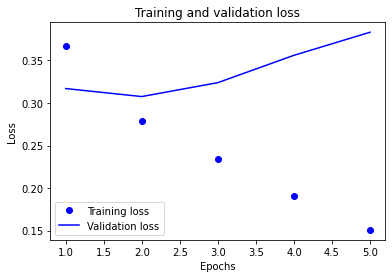

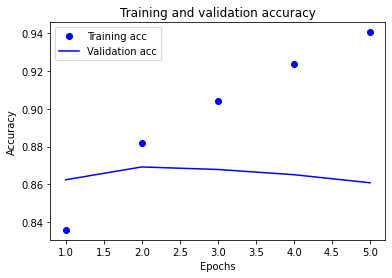

In [25]:
acc = LSTM_history_dict['accuracy']
val_acc = LSTM_history_dict['val_accuracy']
loss = LSTM_history_dict['loss']
val_loss = LSTM_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 5. Model Embeding Layer

### 5-1. GMP Embeding Layer

In [26]:
embedding_layer = GMP_model.layers[0]
weights = embedding_layer.get_weights()[0]
vocab_size, word_vector_dim = weights.shape[0], weights.shape[1]

word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/GMPword2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = GMP_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([-0.22113968, -0.12694141, -0.29312173,  0.03483632,  0.08312398,
       -0.21278925, -0.15625343, -0.04774884, -0.30220821, -0.10127614,
       -0.06806089, -0.05472503, -0.09296846, -0.3940964 ,  0.07126135,
       -0.04218333, -0.05337378, -0.01024793, -0.01795704,  0.09654897,
       -0.23577753, -0.20309232, -0.15063038, -0.27517536, -0.09011236,
       -0.21861365, -0.04741229, -0.32148007, -0.19164468, -0.16211766,
       -0.16509032, -0.00950684, -0.08616982, -0.18122444, -0.14965853,
       -0.14615071, -0.2638386 , -0.2518089 , -0.05288659,  0.13029408,
        0.11463465, -0.03080468, -0.10311409, -0.09356839, -0.13687848,
       -0.20700291, -0.04935448,  0.07986888, -0.278114  , -0.126108  ,
       -0.18234877, -0.11377246, -0.13054256, -0.03597551,  0.1469785 ,
        0.03539316,  0.03985135, -0.04243008, -0.3554609 , -0.20376275,
        0.19944036,  0.00814247,  0.00471031, -0.26093534], dtype=float32)

In [27]:
word_vectors.similar_by_word("로맨스")

[('러브', 0.8180498480796814),
 ('애니메이션', 0.8170689940452576),
 ('전지현', 0.8121035695075989),
 ('고등학생', 0.8081047534942627),
 ('효주', 0.807597279548645),
 ('남', 0.7989218831062317),
 ('인물', 0.7957085371017456),
 ('소지섭', 0.7904224991798401),
 ('엄청난', 0.7837755084037781),
 ('로마', 0.7813882231712341)]

In [28]:
word_vectors.similar_by_word("웅장")

[('추모', 0.6651817560195923),
 ('신디', 0.6582660675048828),
 ('맷데이먼', 0.6561733484268188),
 ('을까요', 0.6559481024742126),
 ('은은', 0.6515401601791382),
 ('문자', 0.6417685151100159),
 ('더락', 0.6329723000526428),
 ('터짐', 0.6323300004005432),
 ('오감', 0.6265091896057129),
 ('햇살', 0.6236127018928528)]

### 5-2. 1-D Convolution Neural Network(1-D CNN) Embeding Layer

In [29]:
embedding_layer = CNN_model.layers[0]
weights = embedding_layer.get_weights()[0]
vocab_size, word_vector_dim = weights.shape[0], weights.shape[1]

word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/CNNword2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = CNN_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([-0.06690209,  0.03688405,  0.14775345, -0.32719925, -0.16572084,
        0.20219867, -0.05386048,  0.06708226, -0.20284252,  0.01444786,
        0.2850529 , -0.23931152, -0.16146237, -0.01825828, -0.13814928,
        0.06261626], dtype=float32)

In [30]:
word_vectors.similar_by_word("로맨스")

[('여요', 0.8963820934295654),
 ('이쁘', 0.841665506362915),
 ('공', 0.8403950929641724),
 ('온전히', 0.8266507387161255),
 ('.;;', 0.8235249519348145),
 ('끝판', 0.8235189914703369),
 ('이래야', 0.7975306510925293),
 ('장백지', 0.7925132513046265),
 ('창조', 0.7893157601356506),
 ('세기', 0.7888184785842896)]

In [31]:
word_vectors.similar_by_word("웅장")

[('성찰', 0.9226086139678955),
 ('잔혹', 0.9189688563346863),
 ('감독판', 0.9107158184051514),
 ('호프만', 0.904621958732605),
 ('린치', 0.9020666480064392),
 ('전두환', 0.8999830484390259),
 ('눈빛', 0.8982130885124207),
 ('묵직', 0.897858738899231),
 ('이연희', 0.8962373733520508),
 ('서글픈', 0.8937170505523682)]

### 5-3. LSTM Embeding Layer 

In [32]:
embedding_layer = LSTM_model.layers[0]
weights = embedding_layer.get_weights()[0]
vocab_size, word_vector_dim = weights.shape[0], weights.shape[1]

word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/LSTMword2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = LSTM_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([ 0.07130896, -0.06814358, -0.12903866,  0.07860702,  0.11338665,
       -0.22274256, -0.0405068 ,  0.1450776 , -0.0208589 ,  0.14494944,
       -0.05593928, -0.23455693, -0.02007249, -0.03786215, -0.00380171,
       -0.10576456,  0.11816386,  0.02580549, -0.05723673, -0.26270968,
       -0.10073559,  0.1423215 ,  0.17127064,  0.06475413, -0.11040932,
       -0.15269494, -0.18598273, -0.05519989,  0.27841094, -0.07280034,
        0.09135974, -0.01911652,  0.08008239, -0.0287342 ,  0.1089934 ,
       -0.20022625,  0.07598377,  0.11552721, -0.04900878, -0.01395044,
        0.05289774,  0.00304849, -0.11380843, -0.13205032,  0.12638676,
       -0.24646822,  0.03160975,  0.12236765,  0.02457389,  0.3375686 ,
       -0.06734288, -0.1051321 ,  0.05330103,  0.07755196,  0.10267287,
       -0.40080017,  0.21891545, -0.38753822, -0.10382024, -0.01568939,
        0.19330089, -0.02036356,  0.24080801,  0.08189351, -0.15784864,
        0.40968648, -0.04423502,  0.01282696, -0.00170878,  0.18

In [33]:
word_vectors.similar_by_word("로맨스")

[('아아아', 0.736332356929779),
 ('이번', 0.7329647541046143),
 ('>', 0.7203007936477661),
 ('시대', 0.7052302956581116),
 ('앞', 0.6993193626403809),
 ('났', 0.6921488046646118),
 ('숨막히', 0.6918244361877441),
 ('영상미', 0.6859076023101807),
 ('이연걸', 0.6822570562362671),
 ('가수', 0.6815158128738403)]

In [34]:
word_vectors.similar_by_word("웅장")

[('싱크로', 0.77757728099823),
 ('미스터', 0.7584331631660461),
 ('첩보', 0.7396438717842102),
 ('브라이언', 0.7391180992126465),
 ('이현우', 0.7363893985748291),
 ('감격', 0.7234395146369934),
 ('아무튼', 0.723291277885437),
 ('쟁쟁', 0.7201427221298218),
 ('세나', 0.7137171626091003),
 ('노년', 0.7131544947624207)]

## 6. 한국어 Word2Vec

In [35]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['컴퓨터']
vector     # 무려 300dim의 워드 벡터입니다.

/tmp/ipykernel_330/928192041.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['컴퓨터']


array([-1.517628  , -0.8935504 , -1.4352998 ,  1.5069847 , -1.5178334 ,
        1.1542678 , -2.94064   ,  1.1850045 ,  0.19959009, -1.5288961 ,
       -1.7067502 , -2.1892095 , -0.20728938, -2.2606812 , -2.2283888 ,
        0.32318738, -0.2845471 , -0.07731772, -0.86269003, -1.1722927 ,
       -0.91062415,  0.8440715 ,  0.903278  , -0.84685427,  0.7023384 ,
       -2.1920419 , -0.47571626, -0.60159504, -0.68860835,  0.18944737,
        0.5319404 ,  0.73058116, -0.9658133 , -1.0123725 , -0.36183038,
        2.5851305 ,  0.66589296, -1.7231252 ,  1.7576753 ,  0.88845277,
        1.5791365 , -4.430691  ,  0.36731872,  0.69481534, -0.46041563,
        1.742655  , -1.5077016 ,  0.72209424, -0.04532204, -0.6557301 ,
       -0.71276623,  0.26522732, -0.17656395, -2.4720876 , -0.845565  ,
        0.23591152,  1.3414925 ,  0.77577615, -2.289371  , -0.8078124 ,
        1.4359473 ,  0.22882733, -1.08867   ,  1.2607764 , -1.7469797 ,
        0.06542054,  0.39896825, -0.3160832 , -1.7257563 ,  0.54

In [36]:
word_vectors.similar_by_word("로맨스")

[('아아아', 0.736332356929779),
 ('이번', 0.7329647541046143),
 ('>', 0.7203007936477661),
 ('시대', 0.7052302956581116),
 ('앞', 0.6993193626403809),
 ('났', 0.6921488046646118),
 ('숨막히', 0.6918244361877441),
 ('영상미', 0.6859076023101807),
 ('이연걸', 0.6822570562362671),
 ('가수', 0.6815158128738403)]

In [37]:
word_vectors.similar_by_word("웅장")

[('싱크로', 0.77757728099823),
 ('미스터', 0.7584331631660461),
 ('첩보', 0.7396438717842102),
 ('브라이언', 0.7391180992126465),
 ('이현우', 0.7363893985748291),
 ('감격', 0.7234395146369934),
 ('아무튼', 0.723291277885437),
 ('쟁쟁', 0.7201427221298218),
 ('세나', 0.7137171626091003),
 ('노년', 0.7131544947624207)]

In [38]:
# model에 사용할 embedding layer 만들기
vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_330/903563256.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_330/903563256.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


### 6-1 GMP

In [39]:
vocab_size = 10000
word_vector_dim = 64

GMP_model = keras.Sequential()
GMP_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
GMP_model.add(keras.layers.GlobalMaxPooling1D())
GMP_model.add(keras.layers.Dense(8, activation='gelu'))
GMP_model.add(keras.layers.Dense(1, activation='sigmoid'))
        

GMP_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 640,529
Trainable params: 640,529
Non-trainable params: 0
_________________________________________________________________


In [40]:
GMP_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

GMP_history = GMP_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=5,
                    batch_size=8,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
13705/13705 [==============================] - 50s 4ms/step - loss: 0.3825 - accuracy: 0.8280 - val_loss: 0.3476 - val_accuracy: 0.8470
Epoch 2/5
13705/13705 [==============================] - 49s 4ms/step - loss: 0.3107 - accuracy: 0.8681 - val_loss: 0.3404 - val_accuracy: 0.8518
Epoch 3/5
13705/13705 [==============================] - 50s 4ms/step - loss: 0.2771 - accuracy: 0.8853 - val_loss: 0.3419 - val_accuracy: 0.8541
Epoch 4/5
13705/13705 [==============================] - 50s 4ms/step - loss: 0.2532 - accuracy: 0.8962 - val_loss: 0.3530 - val_accuracy: 0.8504
Epoch 5/5
13705/13705 [==============================] - 49s 4ms/step - loss: 0.2328 - accuracy: 0.9061 - val_loss: 0.3517 - val_accuracy: 0.8527


In [41]:
results = GMP_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3585 - accuracy: 0.8495
[0.35846182703971863, 0.8495229482650757]


In [42]:
GMP_history_dict = GMP_history.history
print(GMP_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


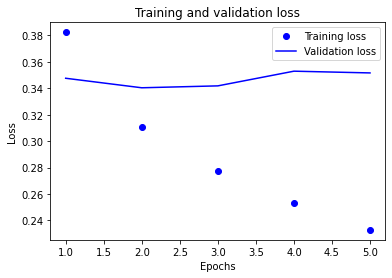

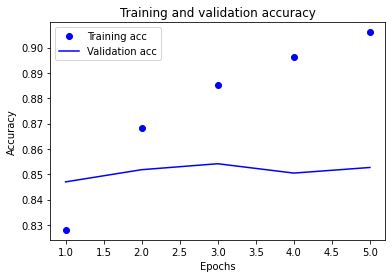

In [43]:
acc = GMP_history_dict['accuracy']
val_acc = GMP_history_dict['val_accuracy']
loss = GMP_history_dict['loss']
val_loss = GMP_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 6-2. 1-D Convolution Neural Network(1-D CNN)

In [44]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

CNN_model = keras.Sequential()
CNN_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
CNN_model.add(keras.layers.Conv1D(16, 7, activation='gelu'))
CNN_model.add(keras.layers.MaxPooling1D(5))
CNN_model.add(keras.layers.Conv1D(16, 7, activation='gelu'))
CNN_model.add(keras.layers.GlobalMaxPooling1D())
CNN_model.add(keras.layers.Dense(8, activation='gelu'))
CNN_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

CNN_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [45]:
CNN_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


CNN_history = CNN_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=5,
                    batch_size=8,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
13705/13705 [==============================] - 69s 5ms/step - loss: 0.3727 - accuracy: 0.8304 - val_loss: 0.3265 - val_accuracy: 0.8590
Epoch 2/5
13705/13705 [==============================] - 68s 5ms/step - loss: 0.2836 - accuracy: 0.8807 - val_loss: 0.3218 - val_accuracy: 0.8605
Epoch 3/5
13705/13705 [==============================] - 67s 5ms/step - loss: 0.2351 - accuracy: 0.9039 - val_loss: 0.3310 - val_accuracy: 0.8586
Epoch 4/5
13705/13705 [==============================] - 68s 5ms/step - loss: 0.1952 - accuracy: 0.9224 - val_loss: 0.3541 - val_accuracy: 0.8540
Epoch 5/5
13705/13705 [==============================] - 67s 5ms/step - loss: 0.1617 - accuracy: 0.9372 - val_loss: 0.4320 - val_accuracy: 0.8429


In [46]:
results = CNN_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4403 - accuracy: 0.8410
[0.44034820795059204, 0.8410195708274841]


In [47]:
CNN_history_dict = CNN_history.history
print(CNN_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


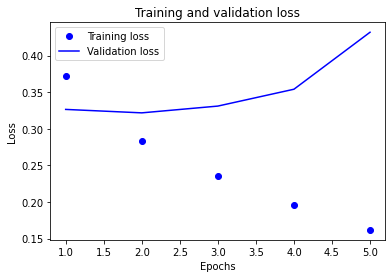

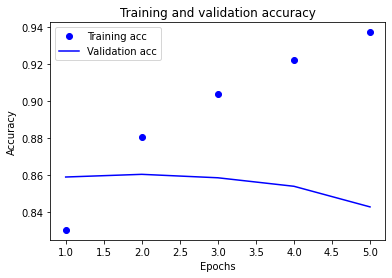

In [48]:
acc = CNN_history_dict['accuracy']
val_acc = CNN_history_dict['val_accuracy']
loss = CNN_history_dict['loss']
val_loss = CNN_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 6-3. LSTM

In [49]:
vocab_size = 10000
word_vector_dim = 128

LSTM_model = keras.Sequential()
LSTM_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM_model.add(keras.layers.LSTM(128))
LSTM_model.add(keras.layers.Dense(1, activation='sigmoid'))

LSTM_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 1,411,713
Trainable params: 1,411,713
Non-trainable params: 0
_________________________________________________________________


In [50]:
LSTM_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


LSTM_history = LSTM_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=5,
                    batch_size=12,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
9137/9137 [==============================] - 55s 6ms/step - loss: 0.3660 - accuracy: 0.8378 - val_loss: 0.3196 - val_accuracy: 0.8609
Epoch 2/5
9137/9137 [==============================] - 53s 6ms/step - loss: 0.2803 - accuracy: 0.8822 - val_loss: 0.3057 - val_accuracy: 0.8698
Epoch 3/5
9137/9137 [==============================] - 53s 6ms/step - loss: 0.2347 - accuracy: 0.9034 - val_loss: 0.3137 - val_accuracy: 0.8676
Epoch 4/5
9137/9137 [==============================] - 53s 6ms/step - loss: 0.1930 - accuracy: 0.9233 - val_loss: 0.3429 - val_accuracy: 0.8630
Epoch 5/5
9137/9137 [==============================] - 53s 6ms/step - loss: 0.1532 - accuracy: 0.9405 - val_loss: 0.3759 - val_accuracy: 0.8604


In [51]:
results = LSTM_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3849 - accuracy: 0.8553
[0.3848874568939209, 0.8552800416946411]


In [52]:
LSTM_history_dict = LSTM_history.history
print(LSTM_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


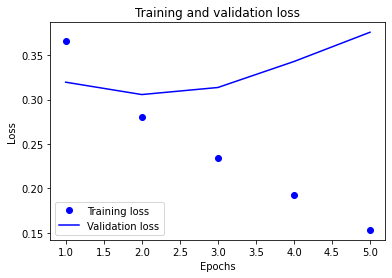

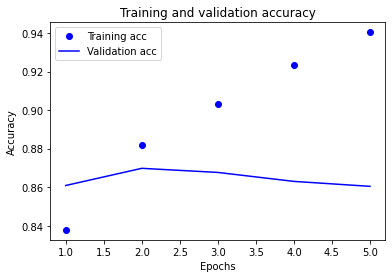

In [53]:
acc = LSTM_history_dict['accuracy']
val_acc = LSTM_history_dict['val_accuracy']
loss = LSTM_history_dict['loss']
val_loss = LSTM_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 회고

1. NLP 오늘 설문조사에서 NLP를 선택했는데 NLP너무 어렵습니다.  
후회 하고있어요.. 그래도 최근 NLP를 경험 하면서 토큰화 하는 부분에 대해서는 어느 정도 익숙해 진 것 같습니다.  
그래도 앞으로의 익스를 통해 NLP 부분에서 다양한 경험을 했으면 좋겠습니다.  

2. epoch, batch size
배치 사이즈를 처음에는 2의 배수로 해야 한 다는 말을 들었는데 큰 의미는 없었던 것 같습니다. 또한 에포크를 늘리거나 줄이는 것 보다 중요한건 적정한 배치 사이즈를 찾는 것 같습니다.  

3. gensim 버전
처음 버전을 굳이 신경쓰지 않고 돌렸는데 오류 때문에 한참을 해매었고 버전을 조정하니 잘 되었습니다.  버전의 중요성을 다시금 알게 되었습니다.  


4. 데이터 선택
데이터는 많으면 많을 수록 좋다고 생각했습니다.  
하지만 이번 데이터 'ko.bin' 파일을 선택하는 부분은 2가지가 있었습니다.  
구글 드라이브와 드롭박스에서 선택 하는 것이였는데요  
드롭박스는 1GB가 넘는 많은 데이터 였고 구글 드라이브 파일은 약 70MB 남짓이였습니다.  그래서 처음에는 드롭박스로 진행을 했었는데 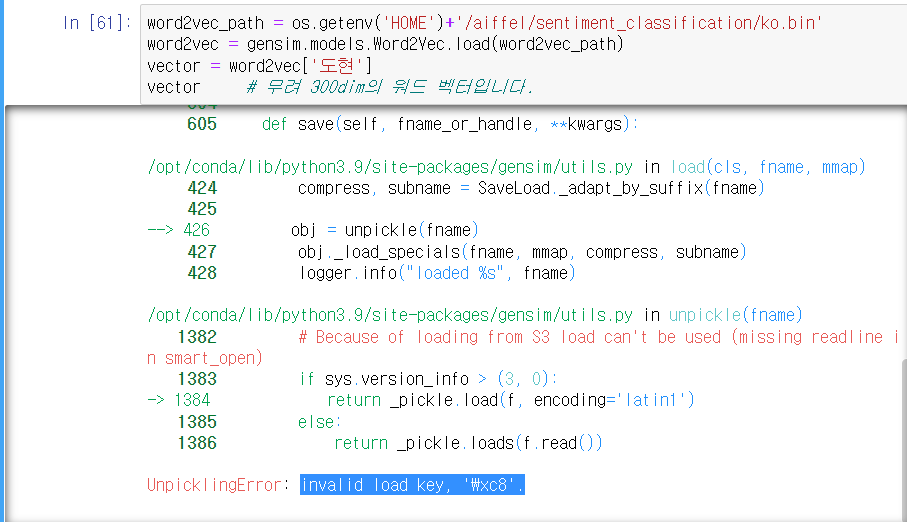 이러한 오류가 나왔습니다.  
검색을 해도 나오지 않았고 코드를 수정해도 좋은 결과가 나오지 않았습니다.  
결과적으로 문제는 단순 '파일'의 문제였습니다.  
그렇기 때문에 이번 프로젝트에서 파일 즉 데이터의 중요성을 다시금 깨닫게 되었습니다.

루브릭 기준 달성
다행히 루브릭 기준의 만족 가능 한 숫자인 LSTM에서 0.8553 나왔습니다.